In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
import tqdm

In [9]:
disk_loc = "/media/jdtho/shiner/v1/scans/"
ignore_objects = {'ceiling', 'floor', 'light',
                  'remove', 'roof', 'wall',
                  'wall frame', 'window frame', 'windowsill'}
# if this appears anywhere in the object name, remove it
ignore_objects_with_substr = {'/', 'frame', 'object', 'other room', 'unknown',
                              'behind'}
# if this appear as a token in obj name, remove them.
strip_words = {'kitchen', 'bath', 'bathroom', 'ceiling', 'wall'}
# replace the key obj w value obj.
rename_objs = {'bin': 'trashcan', 'trash': 'trashcan',
               'shelving': 'shelf', 'countertop': 'counter',
               'smokealarm': 'smokedetector', 'massagebed': 'bed'}
# if these appear in obj name, replace obj name w base.
base_words = {'chair', 'sofa', 'stool', 'table', 'shower'}  

In [13]:
houses = []
for root, dirs, files in os.walk(disk_loc):
    for d in dirs:
        houses.append(d)
    break  # only index top level

In [140]:
# Generate dict from houses to objs to regions to lists of sizes in that region.
# TODO: could add a minimum number of segments of objects are too low-visibility later on.
p2r = {}
house_obj_data = {}  # map from house to object seg info.
all_objs = []
for house in tqdm.tqdm(houses):
    house_obj_data[house] = {}
    
    # Create panorama-to-region map.
    p2r[house] = {}
    p2r_fn = os.path.join(disk_loc, house, house,
                          "house_segmentations", "panorama_to_region.txt")
    if not os.path.isfile(p2r_fn):
        zip_fn = os.path.join(disk_loc, house, "house_segmentations.zip")
        os.system("unzip -o %s -d %s" % (zip_fn, os.path.join(disk_loc, house)))
    with open(p2r_fn, 'r') as f:
        for line in f.readlines():
            _, pid, rid, _ = line.strip().split()
            if int(rid) >= 0:  # discard "-1" regions.
                p2r[house][pid] = rid
    
    # For every region, read in object data and populate structure.
    regions = set(p2r[house].values())
    for rid in regions:
        reg_seg_fn = os.path.join(disk_loc, house, house,
                                  "region_segmentations", "region%s.semseg.json" % rid)
        if not os.path.isfile(reg_seg_fn):
            zip_fn = os.path.join(disk_loc, house, "region_segmentations.zip")
            os.system("unzip -o %s -d %s" % (zip_fn, os.path.join(disk_loc, house)))
        with open(reg_seg_fn, 'r') as f:
            json_str = f.read()
            json_str = json_str.replace("\o", "/ o")
            d = json.loads(json_str)
        for seg in d["segGroups"]:
            obj = seg["label"]
            if np.any([sub in obj for sub in ignore_objects_with_substr]):
                continue
            if obj in ignore_objects:
                continue
            tks = obj.split()
            obj = ''
            # Remove spaces and strip words.
            for tk in tks:
                if tk not in strip_words:
                    obj += tk
            if len(obj) == 0:
                continue
            # Rename if necessary.
            if obj in rename_objs:
                obj = rename_objs[obj]
            # Reduce to base word if necessary.
            for base in base_words:
                if base in obj:
                    obj = base
                    break
            # Lemmatize.
            lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)
            obj = lemmatizer(obj, u"NOUN")[0]
            size = len(seg["segments"])
            
            # Add to house obj structure.
            if obj not in all_objs:
                all_objs.append(obj)
            if obj not in house_obj_data[house]:
                house_obj_data[house][obj] = {}
            if rid not in house_obj_data[house][obj]:
                house_obj_data[house][obj][rid] = []
            house_obj_data[house][obj][rid].append(size)

100%|██████████| 90/90 [00:01<00:00, 62.20it/s]


In [141]:
# Recreate the structure after eliminating objects that do not appear more than
# a threshold of times or are not sufficiently ambiguous within the houses in which they
# appear.
total_across_houses_thresh = 5  # e.g., >5% of houses (out of 90).
total_within_house_thresh = 2

# Total count.
counts = {}
for obj in all_objs:
    r = 0
    for house in houses:
        if obj in house_obj_data[house]:
            r += len(house_obj_data[house][obj])
    counts[obj] = r

# Trim by ambiguity.
trimmed_house_obj_data = {}
orig_obj_count = len(all_objs)
all_objs = []
for house in houses:
    trimmed_house_obj_data[house] = {}
    for obj in house_obj_data[house]:
        if counts[obj] >= total_across_houses_thresh:
            amb_level = len(house_obj_data[house][obj])
            if total_within_house_thresh <= amb_level <= len(set(p2r[house].values())):
                trimmed_house_obj_data[house][obj] = house_obj_data[house][obj]
                if obj not in all_objs:
                    all_objs.append(obj)

print("trimmed from %d unique objects to %d" % (orig_obj_count, len(all_objs)))
house_obj_data = trimmed_house_obj_data

# TODO: Load connectivity maps and trim objects for being too close together
# TODO: and thus not sufficiently ambiguous.

trimmed from 1082 unique objects to 207


In [146]:
# Convert to house -> object -> regions
r2p = {}
for house in houses:
    r2p[house] = {}
    for p in p2r[house]:
        rid = p2r[house][p]
        if rid not in r2p[house]:
            r2p[house][rid] = []
        r2p[house][rid].append(p)

house_obj_regions = {}
for house in houses:
    house_obj_regions[house] = {}
    for obj in house_obj_data[house]:
        house_obj_regions[house][obj] = list(house_obj_data[house][obj].keys())
        
with open('resources/house_obj_regions.json', 'w') as f:
    json.dump(house_obj_regions, f)
with open('resources/house_region_to_panorama.json', 'w') as f:
    json.dump(r2p, f)

0.933(84/90): door
0.922(83/90): chair
0.889(80/90): table
0.833(75/90): picture
0.833(75/90): cabinet
0.822(74/90): window
0.767(69/90): mirror
0.756(68/90): bed
0.733(66/90): pillow
0.722(65/90): sink
0.678(61/90): shelf
0.644(58/90): lamp
0.633(57/90): toilet
0.611(55/90): plant
0.611(55/90): towel
0.600(54/90): curtain
0.578(52/90): couch
0.567(51/90): counter
0.556(50/90): stair
0.522(47/90): nightstand
0.511(46/90): shower
0.489(44/90): tv
0.478(43/90): decoration
0.467(42/90): stool
0.433(39/90): trashcan
0.433(39/90): handrail
0.356(32/90): bathtub
0.333(30/90): desk
0.322(29/90): bench
0.311(28/90): fireplace
0.311(28/90): vase
0.256(23/90): book
0.244(22/90): fan
0.233(21/90): painting
0.233(21/90): pot
0.211(19/90): dresser
0.211(19/90): box
0.200(18/90): washbasin
0.189(17/90): toiletpaper
0.178(16/90): rug
0.178(16/90): step
0.167(15/90): vent
0.156(14/90): column
0.144(13/90): faucet
0.144(13/90): bottle
0.144(13/90): rail
0.144(13/90): beam
0.133(12/90): statue
0.133(12/

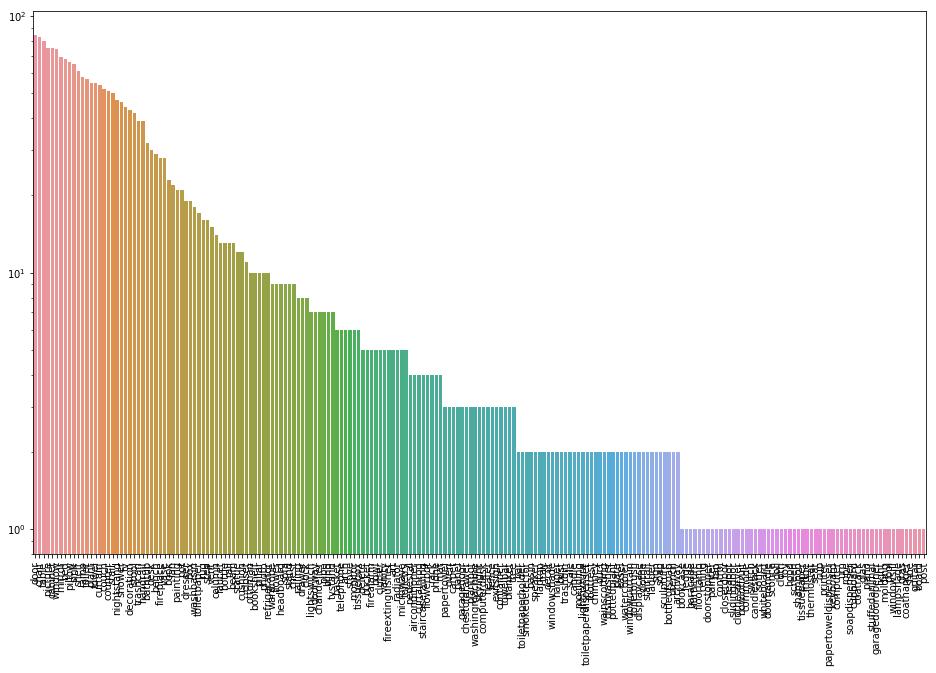

In [143]:
counts = {}
for house in houses:
    for obj in house_obj_data[house]:
        amb_level = len(house_obj_data[house][obj])
        if obj not in counts:
            counts[obj] = 0
        counts[obj] += 1

ordered = sorted(counts.items(), key=lambda x: x[1], reverse=True)
print('\n'.join(["%.3f(%d/%d): %s" % (c / float(len(houses)), c, len(houses), o)
                 for o, c in ordered]))

fig, ax = plt.subplots(figsize=(16, 10))
g = sns.barplot(ax=ax, x=[o[0] for o in ordered], y=[o[1] for o in ordered],
               order=[o[0] for o in ordered])
ax.set(yscale="log")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

1345: door
934: window
745: chair
711: picture
678: table
548: cabinet
383: mirror
349: plant
329: pillow
312: sink
304: curtain
296: lamp
270: shelf
246: bed
218: toilet
214: towel
210: decoration
201: counter
184: stair
177: tv
176: couch
164: trashcan
149: shower
141: nightstand
128: handrail
127: stool
109: desk
107: fireplace
98: fan
90: bench
88: painting
86: vase
80: bathtub
73: vent
67: book
66: duct
65: box
63: column
62: toiletpaper
59: pot
53: washbasin
50: faucet
48: rug
48: pipe
46: step
45: dresser
42: drawer
38: rail
36: pillar
36: arch
35: firealarm
34: chandelier
34: bottle
34: statue
34: beam
32: delete
31: cushion
30: flower
29: doorway
29: stand
28: bookshelf
27: ottoman
27: heater
27: photo
25: monitor
25: clock
24: basket
24: wardrobe
24: lightswitch
24: closet
24: vanity
24: art
23: sofa
23: chest
23: refrigerator
22: railing
22: tissuebox
20: skylight
18: headboard
18: blind
16: wainscotting
16: flowerpot
15: pedestal
15: tvstand
15: toiletry
14: rack
14: sign
1

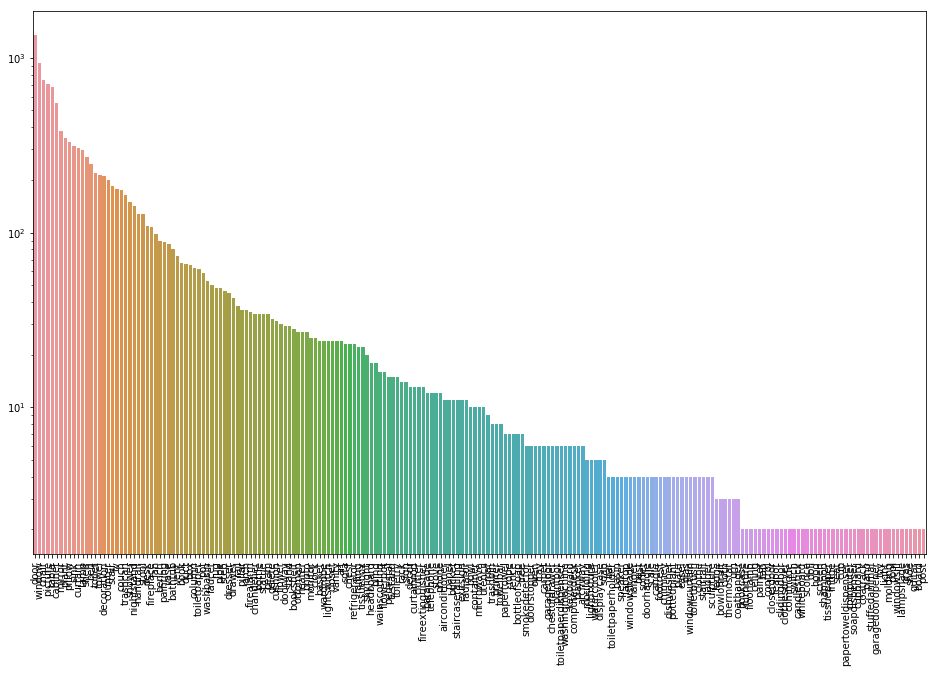

In [144]:
counts = {}
for obj in all_objs:
    r = 0
    for house in houses:
        if obj in house_obj_data[house]:
            r += len(house_obj_data[house][obj])
    counts[obj] = r
    
ordered = sorted(counts.items(), key=lambda x: x[1], reverse=True)
print('\n'.join([str(c) + ": " + o for o, c in ordered]))

fig, ax = plt.subplots(figsize=(16, 10))
g = sns.barplot(ax=ax, x=[o[0] for o in ordered], y=[o[1] for o in ordered],
               order=[o[0] for o in ordered])
ax.set(yscale="log")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

In [18]:
# Unzip skybox images.
for house in tqdm.tqdm(houses):
    skybox_dir = os.path.join(disk_loc, house, "matterport_skybox_images")
    print(skybox_dir)
    if not os.path.isdir(skybox_dir):
        zip_fn = os.path.join(disk_loc, house, "matterport_skybox_images.zip")
        os.system("unzip -o %s -d %s" % (zip_fn, disk_loc))

100%|██████████| 91/91 [00:00<00:00, 2458.81it/s]

/media/jdtho/shiner/v1/scans/JmbYfDe2QKZ/matterport_skybox_images
/media/jdtho/shiner/v1/scans/gZ6f7yhEvPG/matterport_skybox_images
/media/jdtho/shiner/v1/scans/WYY7iVyf5p8/matterport_skybox_images
/media/jdtho/shiner/v1/scans/rqfALeAoiTq/matterport_skybox_images
/media/jdtho/shiner/v1/scans/UwV83HsGsw3/matterport_skybox_images
/media/jdtho/shiner/v1/scans/mJXqzFtmKg4/matterport_skybox_images
/media/jdtho/shiner/v1/scans/ur6pFq6Qu1A/matterport_skybox_images
/media/jdtho/shiner/v1/scans/rPc6DW4iMge/matterport_skybox_images
/media/jdtho/shiner/v1/scans/D7G3Y4RVNrH/matterport_skybox_images
/media/jdtho/shiner/v1/scans/RPmz2sHmrrY/matterport_skybox_images
/media/jdtho/shiner/v1/scans/sKLMLpTHeUy/matterport_skybox_images
/media/jdtho/shiner/v1/scans/s8pcmisQ38h/matterport_skybox_images
/media/jdtho/shiner/v1/scans/q9vSo1VnCiC/matterport_skybox_images
/media/jdtho/shiner/v1/scans/82sE5b5pLXE/matterport_skybox_images
/media/jdtho/shiner/v1/scans/e9zR4mvMWw7/matterport_skybox_images
/media/jdt

In [16]:
for house in tqdm.tqdm(houses):
    policies_dir = os.path.join("/media/jdtho/shiner/", house)
    print("rm -r %s" % policies_dir)

100%|██████████| 91/91 [00:00<00:00, 48628.06it/s]

rm -r /media/jdtho/shiner/JmbYfDe2QKZ
rm -r /media/jdtho/shiner/gZ6f7yhEvPG
rm -r /media/jdtho/shiner/WYY7iVyf5p8
rm -r /media/jdtho/shiner/rqfALeAoiTq
rm -r /media/jdtho/shiner/UwV83HsGsw3
rm -r /media/jdtho/shiner/mJXqzFtmKg4
rm -r /media/jdtho/shiner/ur6pFq6Qu1A
rm -r /media/jdtho/shiner/rPc6DW4iMge
rm -r /media/jdtho/shiner/D7G3Y4RVNrH
rm -r /media/jdtho/shiner/RPmz2sHmrrY
rm -r /media/jdtho/shiner/sKLMLpTHeUy
rm -r /media/jdtho/shiner/s8pcmisQ38h
rm -r /media/jdtho/shiner/q9vSo1VnCiC
rm -r /media/jdtho/shiner/82sE5b5pLXE
rm -r /media/jdtho/shiner/e9zR4mvMWw7
rm -r /media/jdtho/shiner/qoiz87JEwZ2
rm -r /media/jdtho/shiner/Uxmj2M2itWa
rm -r /media/jdtho/shiner/x8F5xyUWy9e
rm -r /media/jdtho/shiner/kEZ7cmS4wCh
rm -r /media/jdtho/shiner/pLe4wQe7qrG
rm -r /media/jdtho/shiner/HxpKQynjfin
rm -r /media/jdtho/shiner/X7HyMhZNoso
rm -r /media/jdtho/shiner/zsNo4HB9uLZ
rm -r /media/jdtho/shiner/ARNzJeq3xxb
rm -r /media/jdtho/shiner/PuKPg4mmafe
rm -r /media/jdtho/shiner/JF19kD82Mey
rm -r /media

In [15]:
houses

['JmbYfDe2QKZ',
 'gZ6f7yhEvPG',
 'WYY7iVyf5p8',
 'rqfALeAoiTq',
 'UwV83HsGsw3',
 'mJXqzFtmKg4',
 'ur6pFq6Qu1A',
 'rPc6DW4iMge',
 'D7G3Y4RVNrH',
 'RPmz2sHmrrY',
 'sKLMLpTHeUy',
 's8pcmisQ38h',
 'q9vSo1VnCiC',
 '82sE5b5pLXE',
 'e9zR4mvMWw7',
 'qoiz87JEwZ2',
 'Uxmj2M2itWa',
 'x8F5xyUWy9e',
 'kEZ7cmS4wCh',
 'pLe4wQe7qrG',
 'HxpKQynjfin',
 'X7HyMhZNoso',
 'zsNo4HB9uLZ',
 'ARNzJeq3xxb',
 'PuKPg4mmafe',
 'JF19kD82Mey',
 'VVfe2KiqLaN',
 'V2XKFyX4ASd',
 'ULsKaCPVFJR',
 'gTV8FGcVJC9',
 '1LXtFkjw3qL',
 '2t7WUuJeko7',
 '1pXnuDYAj8r',
 'wc2JMjhGNzB',
 'fzynW3qQPVF',
 'jh4fc5c5qoQ',
 'D7N2EKCX4Sj',
 'Z6MFQCViBuw',
 'VLzqgDo317F',
 '2n8kARJN3HM',
 '2azQ1b91cZZ',
 'vyrNrziPKCB',
 'QUCTc6BB5sX',
 '759xd9YjKW5',
 'XcA2TqTSSAj',
 'SN83YJsR3w2',
 'r1Q1Z4BcV1o',
 'oLBMNvg9in8',
 'YmJkqBEsHnH',
 '5LpN3gDmAk7',
 'B6ByNegPMKs',
 'sT4fr6TAbpF',
 'YVUC4YcDtcY',
 'dhjEzFoUFzH',
 'GdvgFV5R1Z5',
 'VzqfbhrpDEA',
 'ZMojNkEp431',
 'gYvKGZ5eRqb',
 '17DRP5sb8fy',
 'matterport_skybox_images',
 'TbHJrupSAjP',
 'EDJbREhgh